In [1]:
#Cargamos las librerías necesarias para el análisis
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA 
from sklearn.preprocessing import normalize
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import pandas as pd
import time 
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.io import loadmat

In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat
from PIL import Image
from io import BytesIO
import os

def show_whats_written(df, output_path, file):
    # Filter the DataFrame
    filtered_df = df[(df.X != 683) & (df.Y != 384)]

    # Create a line plot for the clean data
    plt.plot(filtered_df['X'], filtered_df['Y'])

    # Add labels and a title
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.title(f'X vs. Y Coordinates - Trial {trial}')

    file_name = file.split('.')[0]

    # Save the plot as an image
    image_filename = os.path.join(output_path, f'{file_name}.png')
    print(image_filename)
    plt.savefig(image_filename)

    plt.close()

    # Show the plot
    # plt.show()

data_groups = ["HC","Left_MAS","Right_MAS"]
data_groups = list(data_groups)

# Use os.walk to traverse all subdirectories and process MAT files
for group in data_groups: 
    # Define the path to your data group folder
    data_group_path = "../data/Francis_data/Francis_data/Baseline_fmri/"+group
    
    for root, _, files in os.walk(data_group_path):
        i=0
        for file in files:
            if file.endswith(".mat"):
                file_path = os.path.join(root, file)

                patient_folder = file_path.split('/')[5].split("\\")[1]

                # Load data from the MAT file
                data = loadmat(file_path)
                trial = int(data['S']['trial_cond'][0][0][i][0])
                print(trial)

                thePoints = data['S']['thePoints'][0][0]
                file_data = np.array([thePoints[:, 0], thePoints[:, 1]]).T
                df = pd.DataFrame(file_data)
                df.rename(columns={0: "X", 1: "Y"}, inplace=True)

                # Create output folder structure 
                # output_folder = "..\output\\"+group+"\\"+patient_folder+"\\"+str(trial)
                # os.makedirs(output_folder, exist_ok=True)

                # # Generate and save the plot
                # show_whats_written(df, output_folder, file)

                i=i+1


../data/Francis_data/Francis_data/Baseline_fmri/HC
../data/Francis_data/Francis_data/Baseline_fmri/Left_MAS
../data/Francis_data/Francis_data/Baseline_fmri/Right_MAS


In [2]:
# import pandas as pd
# import numpy as np
# import matplotlib.pyplot as plt
# from scipy import stats
# from PIL import Image
# from io import BytesIO


# def show_whats_written(df):

#     # Filter the DataFrame 
#     filtered_df = df[(df.X != 683) & (df.Y != 384)]   

#     # Create a line plot for the clean data
#     plt.plot(filtered_df['X'], filtered_df['Y'])

#     # Add labels and a title
#     plt.xlabel('X')
#     plt.ylabel('Y')
#     plt.title('X vs. Y Coordinates (Line Plot without Outliers)')


#     # # Save the plot as an image
#     # plt.savefig('clean_data_plot.png')

#     # # Convert the plot to an image object
#     # buffer = BytesIO()
#     # plt.savefig(buffer, format='png')
#     # buffer.seek(0)
#     # image = Image.open(buffer)

#     # # Save the image as a file
#     # image.save('clean_data_image.png')

#     # Show the plot
#     plt.show()

3


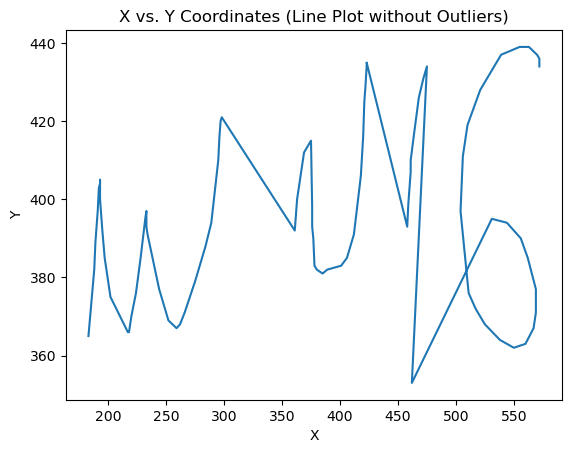

3


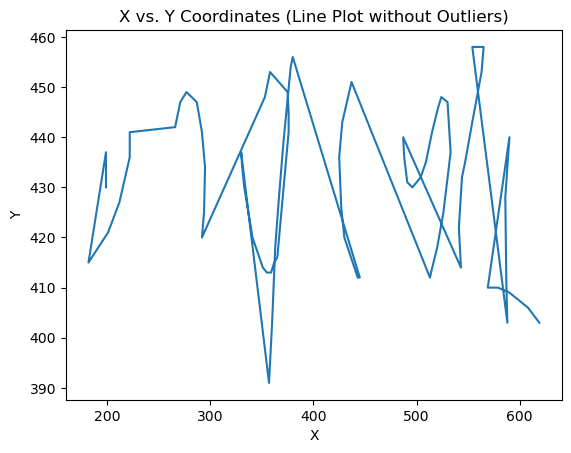

3


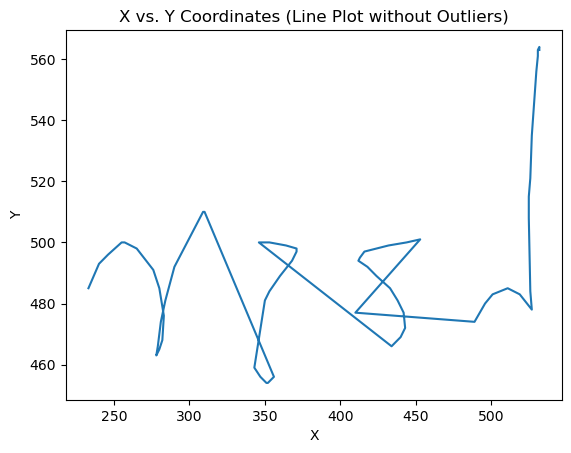

3


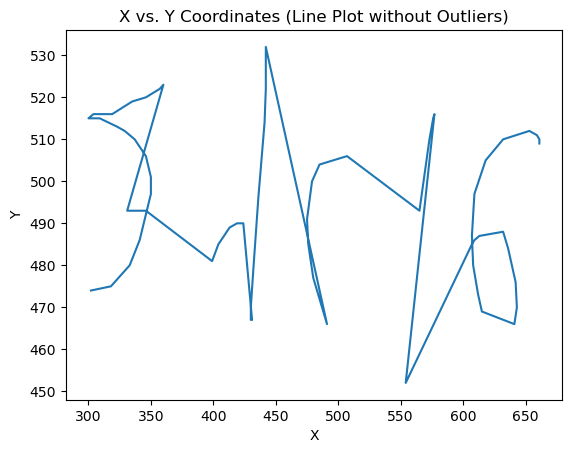

3


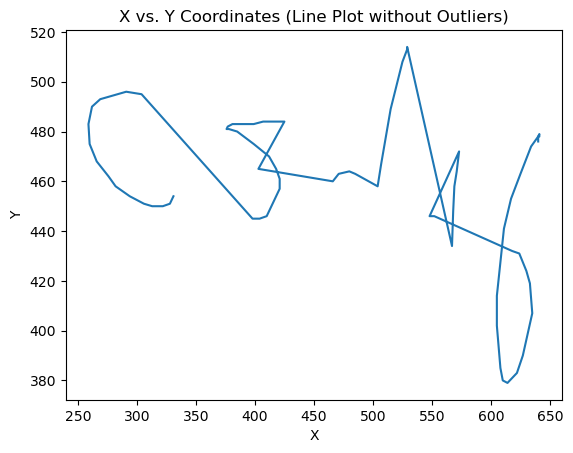

3


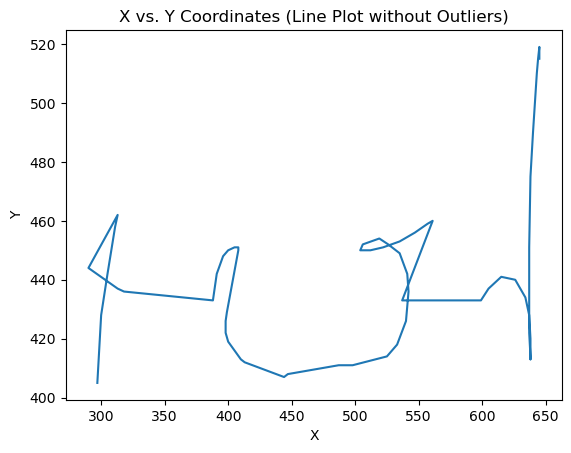

3


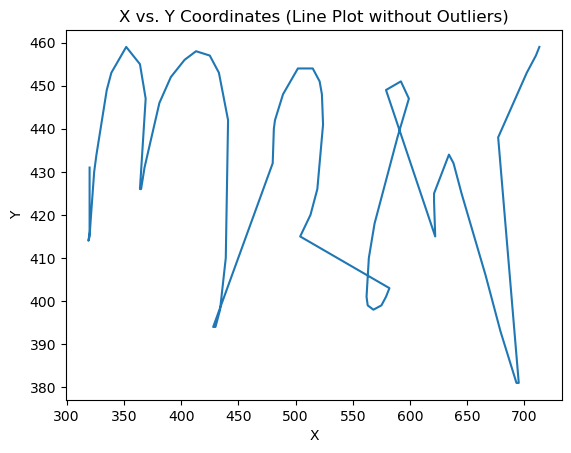

3


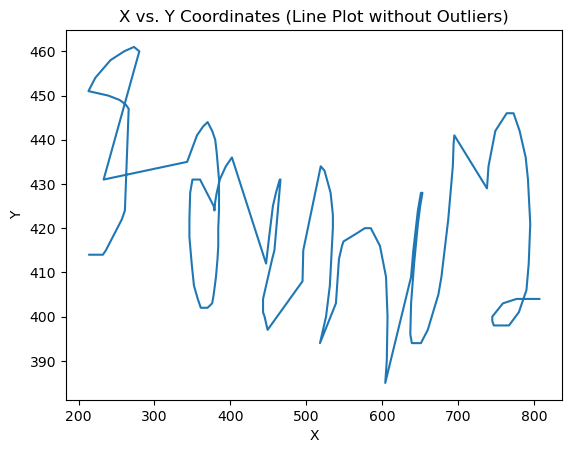

3


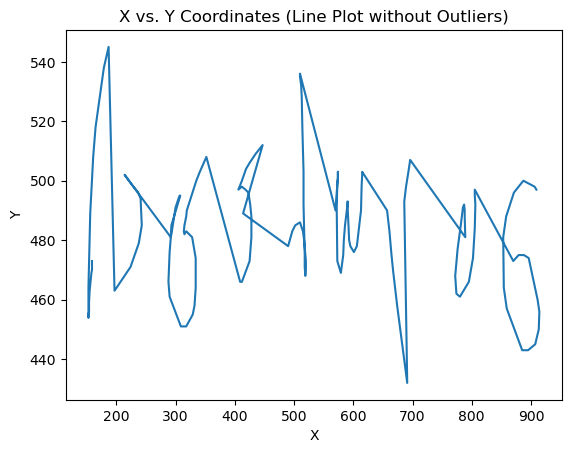

3


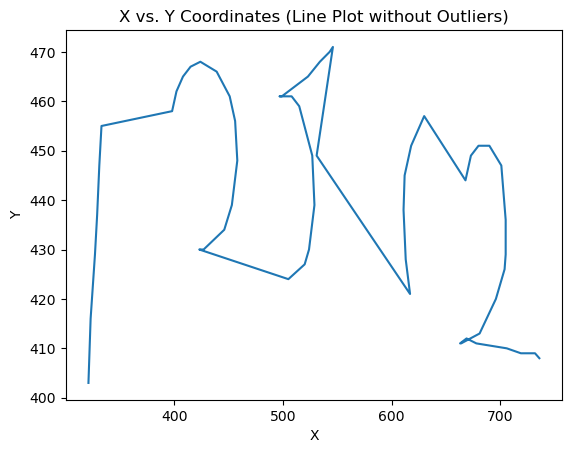

In [49]:
# import glob

# # Define the path to your MAT files

# data_group = ["HC",1]

# mat_files_path = "../data/Francis_data/Francis_data/Baseline_fmri/"+data_group[0]+"/Habits_70/*.mat"

# # Use glob to get a list of all matching MAT files
# mat_files = sorted(glob.glob(mat_files_path))

# # Get the last 20 MAT files
# mats = mat_files[:40]

# i=0
# file_data = []

# for file in mats:
#     data = loadmat(file)

#     thePoints=data['S']['thePoints'][0][0]  
#     Sbuttons=data['S']['Sbuttons'] 
#     timeSeries=data['S']['Ts'][0][0][0] # seleccionamos el tiempo
#     trial= int(data['S']['trial_cond'][0][0][i][0]) 
#     finishTime=data['S']['Ts'][0][0][0][-1]
#     length=len(Sbuttons[0][0]) 
#     rule = timeSeries[-1]/length 
#     currenTimeSeries = np.transpose(np.arange(start=0, stop=timeSeries[-1]+rule, step=rule)) 
    
#     # print(file)
#     # print(trial) #Tipo experimento
#     # print(currenTimeSeries[-1]) #Tiempo experimento

#     # if(trial == 3):

#     file_data = np.array([thePoints[:,0], thePoints[:,1]]).T

#     # # Print the file name
#     print(trial)
#     df=pd.DataFrame(file_data)
#     # df.rename(columns={0: "time", 1: "X", 2: 'Y', 3: 'cond'}, inplace=True)
#     df.rename(columns={0: "X", 1: "Y"}, inplace=True)
#     # print(df)
#     # check_outliers(df)
#     show_whats_written(df)

#     i=i+1


,X,Y
0,683,384
1,683,384
2,683,384
3,683,384
4,683,384
...,...,...
1632,315,114
1633,315,114
1634,315,114
1635,315,114


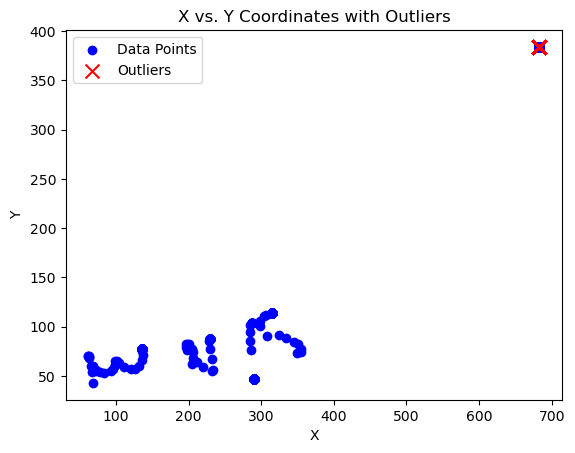

Outliers:
       X    Y  X_ZScore  Y_ZScore
0    683  384  2.011226  2.094934
1    683  384  2.011226  2.094934
2    683  384  2.011226  2.094934
3    683  384  2.011226  2.094934
4    683  384  2.011226  2.094934
..   ...  ...       ...       ...
289  683  384  2.011226  2.094934
290  683  384  2.011226  2.094934
291  683  384  2.011226  2.094934
292  683  384  2.011226  2.094934
293  683  384  2.011226  2.094934

[294 rows x 4 columns]


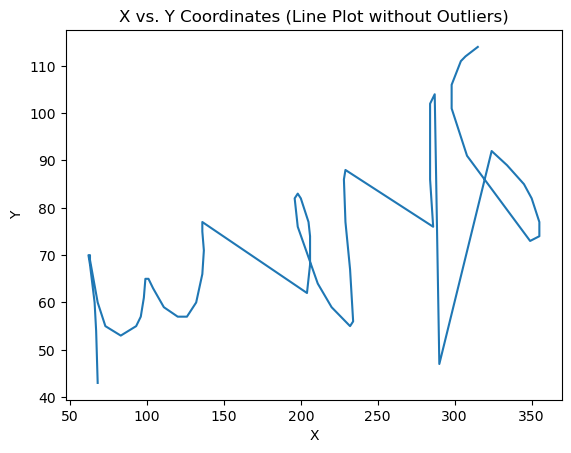

In [ ]:
import base64
import pickle

# Serialize the clean data and convert it to a base64-encoded string
serialized_data = pickle.dumps(filtered_df)
encoded_data = base64.b64encode(serialized_data).decode('utf-8')

# Create a DataFrame with the encoded data
df = pd.DataFrame({'Clean Data': [encoded_data]})

# # To save the DataFrame to a file (e.g., a CSV file)
# df.to_csv('data_with_clean_coordinates.csv', index=False)

# # To read the DataFrame back from the CSV file
# loaded_df = pd.read_csv('data_with_clean_coordinates.csv')

# Retrieve the encoded data from the loaded DataFrame
encoded_data = df['Clean Data'].iloc[0]

# Decode the data and unpickle it
decoded_data = base64.b64decode(encoded_data.encode('utf-8'))
retrieved_clean_data = pickle.loads(decoded_data)

In [ ]:
retrieved_clean_data

,X,Y,X_ZScore,Y_ZScore
294,68,43,1.755607,0.946878
295,67,54,1.761732,0.848755
296,66,60,1.767857,0.795234
297,63,68,1.786232,0.723871
298,62,70,1.792356,0.706031
...,...,...,...,...
1632,315,114,0.242749,0.313539
1633,315,114,0.242749,0.313539
1634,315,114,0.242749,0.313539
1635,315,114,0.242749,0.313539
